In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import statsmodels.api as sm
import warnings
from scipy.linalg import eigh
warnings.filterwarnings(action='ignore')

## Theory of implementation

### Fractional Brownian Motion
- Rough models of stochastic volatility replace an ordinary Brownian motion driving the dynamics of volatility with a fractional 
Brownian motion (fBM). 
- The fBM family, indexed by a single parameter, includes ordinary Brownian motion and also processes with smoother and rougher paths.
- A fractional Brownian motion with Hurst parameter $H ∈ (0, 1)$ is a mean-zero Gaussian process ${W_t^H , −∞ < t < ∞}$ with stationary increments and covariance function given by
$$
\mathbb{E} \big[ W^H (t) W^H (s) \big] = \frac{1}{2} \Big( |t|^{2H} + |s|^{2H} - |t - s|^{2H} \Big)  \quad\quad -(1)
$$

- The case $H = 1/2$ corresponds to ordinary Brownian motion. With $H ∈ (1/2,1)$, fractional Brownian motion exhibits long-range dependence; processes with $H ∈ (0, 1/2)$ have paths that are rougher than those of ordinary Brownian motion, with small H indicating greater roughness.
- We have the following property of the moments of the increments of fractional Brownian motion. For any $t ∈ R$, and $∆ ≥ 0$, and any $q > 0$,
$$
\mathbb{E} \big[ |W^H_{t+\Delta} - W^H_t|^q \big] = \mathbb{E} \big[ |Z|^q \big] \Delta^ {qH}, 
\quad Z \sim N(0,1)  \quad\quad -(2)
$$

- With smaller H, increments over a short interval ∆ have larger moments.



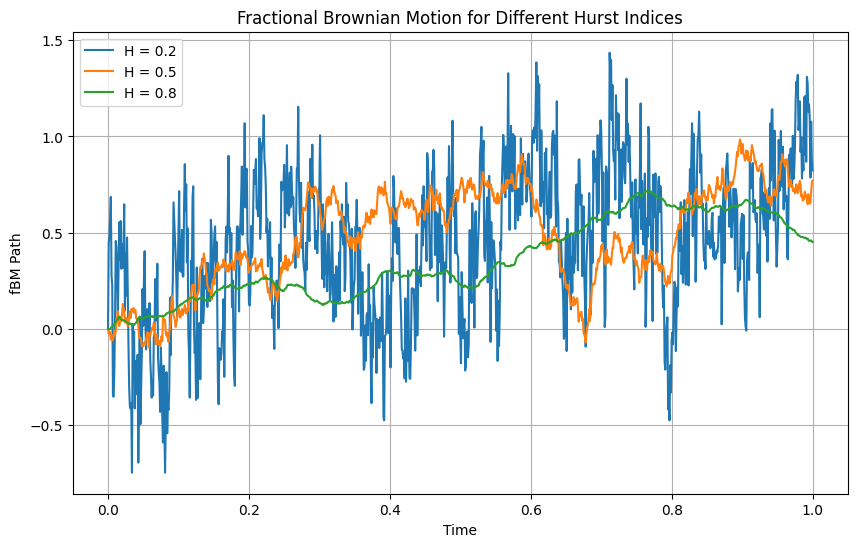

In [84]:
def fbm(T, N, H):
    dt = T / N
    t = np.linspace(0, T, N+1)
    gamma = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            gamma[i, j] = 0.5 * (abs(i * dt)**(2*H) + abs(j * dt)**(2*H) - abs((i-j) * dt)**(2*H))
    eigvals, eigvecs = eigh(gamma)
    eigvals = np.maximum(eigvals, 0) 
    L = eigvecs @ np.diag(np.sqrt(eigvals))
    np.random.seed(42)
    Z = np.random.randn(N+1)
    W = np.dot(L, Z)
    return t, W
T = 1.0   
N = 1000 
H_values = [0.2, 0.5, 0.8]
plt.figure(figsize=(10, 6))
for H in H_values:
    t, W = fbm(T, N, H)
    plt.plot(t, W, label=f"H = {H}")
plt.xlabel("Time")
plt.ylabel("fBM Path")
plt.title("Fractional Brownian Motion for Different Hurst Indices")
plt.legend()
plt.grid()
plt.show(block=True)

### Rough Volatility Model
- As an example of a rough volatility model for an asset price ${St, t ≥ 0}$, we could set

$$
d \log S_t = \mu \, dt + \sigma_t \, dW_t, \quad \quad - (3)
$$
$$
d \log \sigma_t = \nu \, dW_t^H; \quad \quad -(4)
$$

- Here, $μ, κ, m,$ and $ν$ are constants, $W$ is an ordinary Brownian motion, $W^H$ is a fractional Brownian motion with $H ∈ (0,1/2)$, and $W$ and $W^H$ may be correlated. The parameter $H$ determines the roughness of the volatility process.
- Rough volatility arises from mixing mean-reverting volatility processes with different speeds of mean reversion, driven by an ordinary Brownian motion, including components with arbitrarily fast mean reversion.



### One method of estimating realized H values
- If we could observe logσt at times t = 0,∆,2∆,... for some small ∆ > 0, we could estimate H by estimating the below equation for various values of q > 0, and then applying (2) to extract H 

$$
\mathbb{E} \big[ | \log \sigma_{t+\Delta} - \log \sigma_t |^q \big] \quad\quad - (5)
$$



### Implemented method of estimating realized H values
- In practice, $σ_t$ cannot be observed and must be estimated, so we proceed as follows. Using trades from the Trade and Quote (TAQ) data, we estimate the daily integrated variance of returns; taking the square root yields our estimated daily volatility.

- The rest of the estimation procedure works with these daily volatilities, which we write as $σ_d$, with $d$ indexing days. We apply (5) with $q = 2$, estimating second moments over intervals of ℓ days, ℓ= 1,2,...,10. In each month, for each stock and each lag ℓ, we calculate (T is the number of days in the month):
$$
z_2(\ell) = \frac{1}{T - \ell} \sum_{d=1}^{T - \ell} \big( \log \hat{\sigma}_{d+\ell} - \log \hat{\sigma}_d \big)^2, \quad\quad -(6)
$$

- Based on (2), we expect
$$
z_2(\ell) \approx \nu^2 \ell^{2H}. \quad\quad -(7)
$$

- So to estimate H we run a regression

$$
\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon, \quad\quad -(8)
$$
- We estimate H as $β_2/2$. We also estimate the volatility of volatility $ν$ by setting $log ν = β_1/2$. This procedure yields an estimate of $H$ (and $ν$) for each stock in each month.


## Data import and cleaning

In [85]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

,industry,top_tickers
0,US Consumer Discretionary,AMZN
1,US Consumer Discretionary,TSLA
2,US Consumer Discretionary,HD
3,US Consumer Discretionary,WMT
4,US Consumer Discretionary,MCD


In [86]:
vols = pd.read_csv('../daily_vol_series.csv')
vols = vols[vols['SYM_ROOT'] == vols['symbol']]
vols = vols.merge(industries, left_on='SYM_ROOT', right_on='top_tickers', how='inner')
vols = vols[['DATE', 'SYM_ROOT', 'industry', 'ivol_t', 'ivol_q']]
vols = vols[vols['DATE'] <= '2023-08-31']
vols.head()

,DATE,SYM_ROOT,industry,ivol_t,ivol_q
0,2010-01-04,AAPL,US Technology,6.140084e-09,4.300400e-10
1,2010-01-05,AAPL,US Technology,5.997564e-09,3.934783e-10
2,2010-01-06,AAPL,US Technology,5.785301e-09,5.765893e-10
3,2010-01-07,AAPL,US Technology,9.102045e-09,6.425180e-10
4,2010-01-08,AAPL,US Technology,6.838924e-09,5.694237e-10


In [87]:
vols['month'] = pd.to_datetime(vols['DATE']).dt.month
vols['year'] = pd.to_datetime(vols['DATE']).dt.year
vols['ivol_q_log'] = np.log(vols['ivol_q'])

## Calculating $z_2(\ell)$ for $l={1,2,3 \dots 10}$

In [88]:
def moments(df):
    final_dfs = []
    for lag in range(1, 11):
        tmp = df.groupby(['SYM_ROOT', 'industry', 'year', 'month'])['ivol_q_log']\
            .apply(lambda x: (((x - x.shift(lag))**2).sum() / (x.count() - lag)) ).to_frame(f'lag{lag}_mom')
        final_dfs.append(tmp)
    final_df = pd.concat(final_dfs, axis=1)
    return final_df

In [89]:
final = moments(vols)
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.dropna(inplace=True)
final.head()


lag1_mom   lag2_mom   lag3_mom   lag4_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.124012   0.171654   0.142317   0.237785   
                            2       0.067225   0.125021   0.179476   0.244710   
                            3       0.177133   0.242053   0.198273   0.162382   
                            4       0.193675   0.272393   0.313740   0.403786   
                            5      15.892976  25.353659  28.885627  29.800796   

                                    lag5_mom   lag6_mom   lag7_mom   lag8_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.328099   0.400266   0.529878   0.649329   
                            2       0.314723   0.386906   0.497555   0.595319   
                            3       0.257832   0.319519   0.226560   0.246481   
                            4       0.411080   0.405068   0.399077   0.554030   
                            5      15.897322  16.978581  17.957950  19.168883   

                                    lag9_mom  lag10_mom  
SYM_ROOT industry      year month                        
AAPL     US Technology 2010 1       0.675741   0.825034  
                            2       0.644346   0.776623  
                            3       0.261480   0.348716  
                            4       0.698151   0.725557  
                            5      20.298034  22.192187

## Regressing $\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon$ to find H


In [90]:
betas = pd.DataFrame(columns=['Betas'], index=final.index)
for idx,_ in final.iterrows():
    y = final.loc[idx].values
    X = np.log(range(1, 11)).reshape(-1,1)
    # X = sm.add_constant(X) # to ensure positive H-vals
    mod = sm.OLS(y, X).fit()
    betas.loc[idx, 'Betas'] = mod.params[0]
betas.reset_index(inplace=True)
betas['Realized_H'] = betas['Betas'] * 0.5
betas.head()

,SYM_ROOT,industry,year,month,Betas,Realized_H
0,AAPL,US Technology,2010,1,0.275441,0.13772
1,AAPL,US Technology,2010,2,0.261588,0.130794
2,AAPL,US Technology,2010,3,0.142099,0.071049
3,AAPL,US Technology,2010,4,0.275366,0.137683
4,AAPL,US Technology,2010,5,11.469401,5.734701


## Exploratory Analysis on the Realized H values

In [91]:
# analysis_industries=['US Consumer Discretionary', 'US Consumer Staples', 'US Energy', 'US Financials', 'US Healthcare', 'US Industrials', 'US Technology', 'US Materials', 'US Real Estate & REITs', 'US Utilities', 'US Media & Communications']
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']

In [92]:
industry_monthly_H=betas.groupby(['industry','year','month'])['Realized_H'].mean().reset_index()
industry_monthly_H['month_plot'] = (pd.to_datetime(industry_monthly_H[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)).dt.to_period('M')
industry_monthly_H=industry_monthly_H.drop(columns=['year','month'])
industry_monthly_H=industry_monthly_H.pivot(index='month_plot', columns='industry',values='Realized_H')
industry_monthly_H=industry_monthly_H.drop(['US Technology'], axis=1)
industry_monthly_H=industry_monthly_H.astype(float)
industry_monthly_H2=industry_monthly_H[analysis_industries]

# industry_monthly_H2=industry_monthly_H2.loc['2020':'2020']
industry_monthly_H2.head()


industry,US Consumer Discretionary,US Consumer Staples,US Energy,US Financials,US Healthcare
month_plot,,,,,
2010-01,0.074600,0.072495,0.141322,0.063888,0.118234
2010-02,0.045979,0.047832,0.089387,0.053811,0.119026
2010-03,0.056483,0.059420,0.148666,0.053147,0.119567
2010-04,0.047980,0.122197,0.093371,0.082539,0.104243
2010-05,1.033379,0.840161,0.273550,0.126977,0.431969


In [93]:
volind = vols.copy()
volind['log_ivol_q'] = np.log(volind['ivol_q'])
volind = volind.loc[:, ['log_ivol_q', 'industry', 'DATE']]
volind['DATE'] = pd.to_datetime(volind['DATE'])
volind = volind.groupby(['industry', 'DATE'])['log_ivol_q'].mean().reset_index()
volind = volind.pivot(index='DATE', columns='industry', values='log_ivol_q')
volind_rolling_autocorr = volind.rolling(window=20).apply(lambda x: x.autocorr(lag=1))
volind


industry,US Consumer Discretionary,US Consumer Staples,US Energy,US Financials,US Healthcare,US Industrials,US Materials,US Media & Communications,US Real Estate & REITs,US Technology,US Utilities
DATE,,,,,,,,,,,
2010-01-04,-20.173136,-20.511107,-19.227885,-20.611985,-20.144946,-19.978464,-19.379862,-20.320205,-18.645059,-18.836624,-19.661147
2010-01-05,-20.503349,-20.918620,-19.703490,-20.613185,-20.167389,-20.018751,-19.461897,-20.279885,-19.119235,-19.210230,-19.801055
2010-01-06,-20.314266,-20.504699,-19.555739,-20.617759,-20.264695,-20.168554,-19.237858,-20.055886,-18.912264,-18.859894,-19.772409
2010-01-07,-20.042726,-20.453135,-19.446017,-20.459591,-19.977748,-19.862960,-19.458790,-20.118157,-18.772621,-18.846043,-19.374587
2010-01-08,-20.138133,-20.218780,-19.697670,-20.326314,-20.160307,-19.905233,-19.357033,-20.185039,-18.849742,-19.192921,-19.568307
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,-20.623012,-20.868513,-20.393680,-20.517068,-20.107140,-19.868051,-19.648181,-20.265433,-19.212326,-20.437445,-20.114373
2023-08-28,-20.620390,-21.107499,-20.467490,-20.672315,-20.318842,-20.101150,-20.007389,-20.538212,-19.372106,-20.663704,-20.098856
2023-08-29,-20.743075,-21.032421,-20.501596,-20.717565,-20.288019,-19.976291,-19.822210,-20.541756,-19.498418,-20.834265,-20.070615


### Heatmap of correlations between realized H-values of different industries

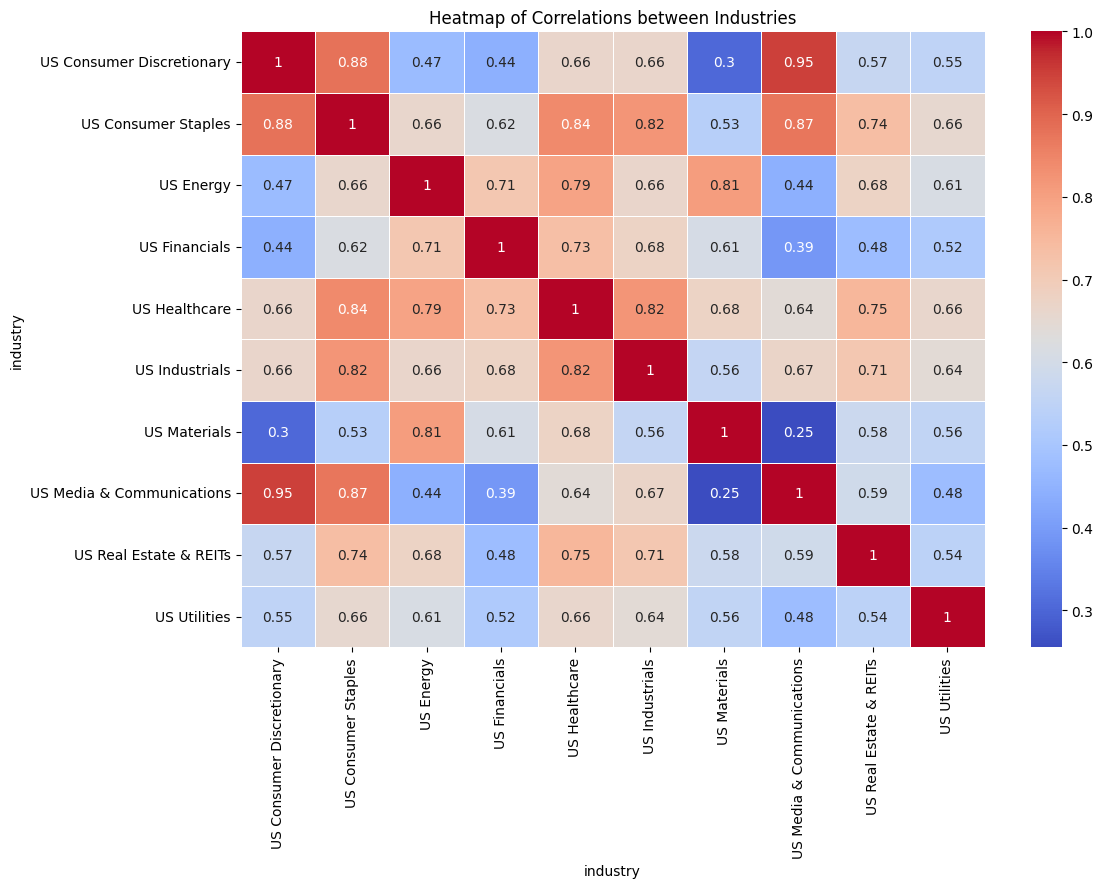

In [94]:
industry_monthly_H
plt.figure(figsize=(12, 8))
sns.heatmap(industry_monthly_H.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Industries')
plt.show()

#### Observations:

- Except 5 pairs, all other industries see decently correlated monthly H values (>0.6)
- The highest correlations noticed among the pairs of Consumer Staples, Consumer Discretionary and Media&Communications (all pair correlations >= 0.87), indicating that these industries react to shocks in an almost identical manner.
- Lowest correlations noticed amongst industries like Materials and Media, Materials and Consumerables. It shows that the shocks to the prices of these industrial tickers are mostly unrelated and each follow a relatively more independent behaviour.

#### Economic Explanations:

- Strong positive correlations (Values close to 1)
    - US Consumer Discretionary & US Media & Communications (0.95): This strong positive correlation suggests that these two sectors tend to move in the same direction. This could be because consumer spending on discretionary items is often influenced by media and communication trends (e.g., advertising, entertainment). When the economy is doing well, consumers are more likely to spend on both.

    - US Consumer Discretionary & US Consumer Staples (0.88): This high correlation suggests a relationship between consumer cyclical and non-cyclical spending. When the economy is strong, people buy more of both.

- Moderate to Strong Positive Correlations (Values between 0.5 and 0.85)
    - US Healthcare & US Consumer Staples (0.84): These sectors often show a positive correlation as demand is less sensitive to economic cycles. People still need healthcare and basic goods regardless of the economy.

    - US Energy & US Healthcare (0.79): The cost of energy impacts healthcare, and vice versa.

    - US Industrials & US Healthcare (0.82): Industrial production is required for healthcare supplies.

    - US Industrials & US Consumer Staples (0.82): Same explanation as above.

    - US Energy & US Financials (0.71): Energy companies often rely on financing, and the performance of the energy sector can impact financial institutions. Energy sector impacts nearly all other sectors through energy costs.

- Weak Correlations (Values below 0.35)

    - US Materials & US Media & Communications (0.25): It suggests that the performance of the materials sector (which includes companies that discover, develop, and process raw materials) has little relationship with the media and communications sector.

    - US Materials & US Consumer Discretionary (0.3): Another weak correlation, indicating that the materials sector doesn't move closely with consumer discretionary spending.

### Visualization of Daily volatilities, their lagged autocorrelation and realized H-values

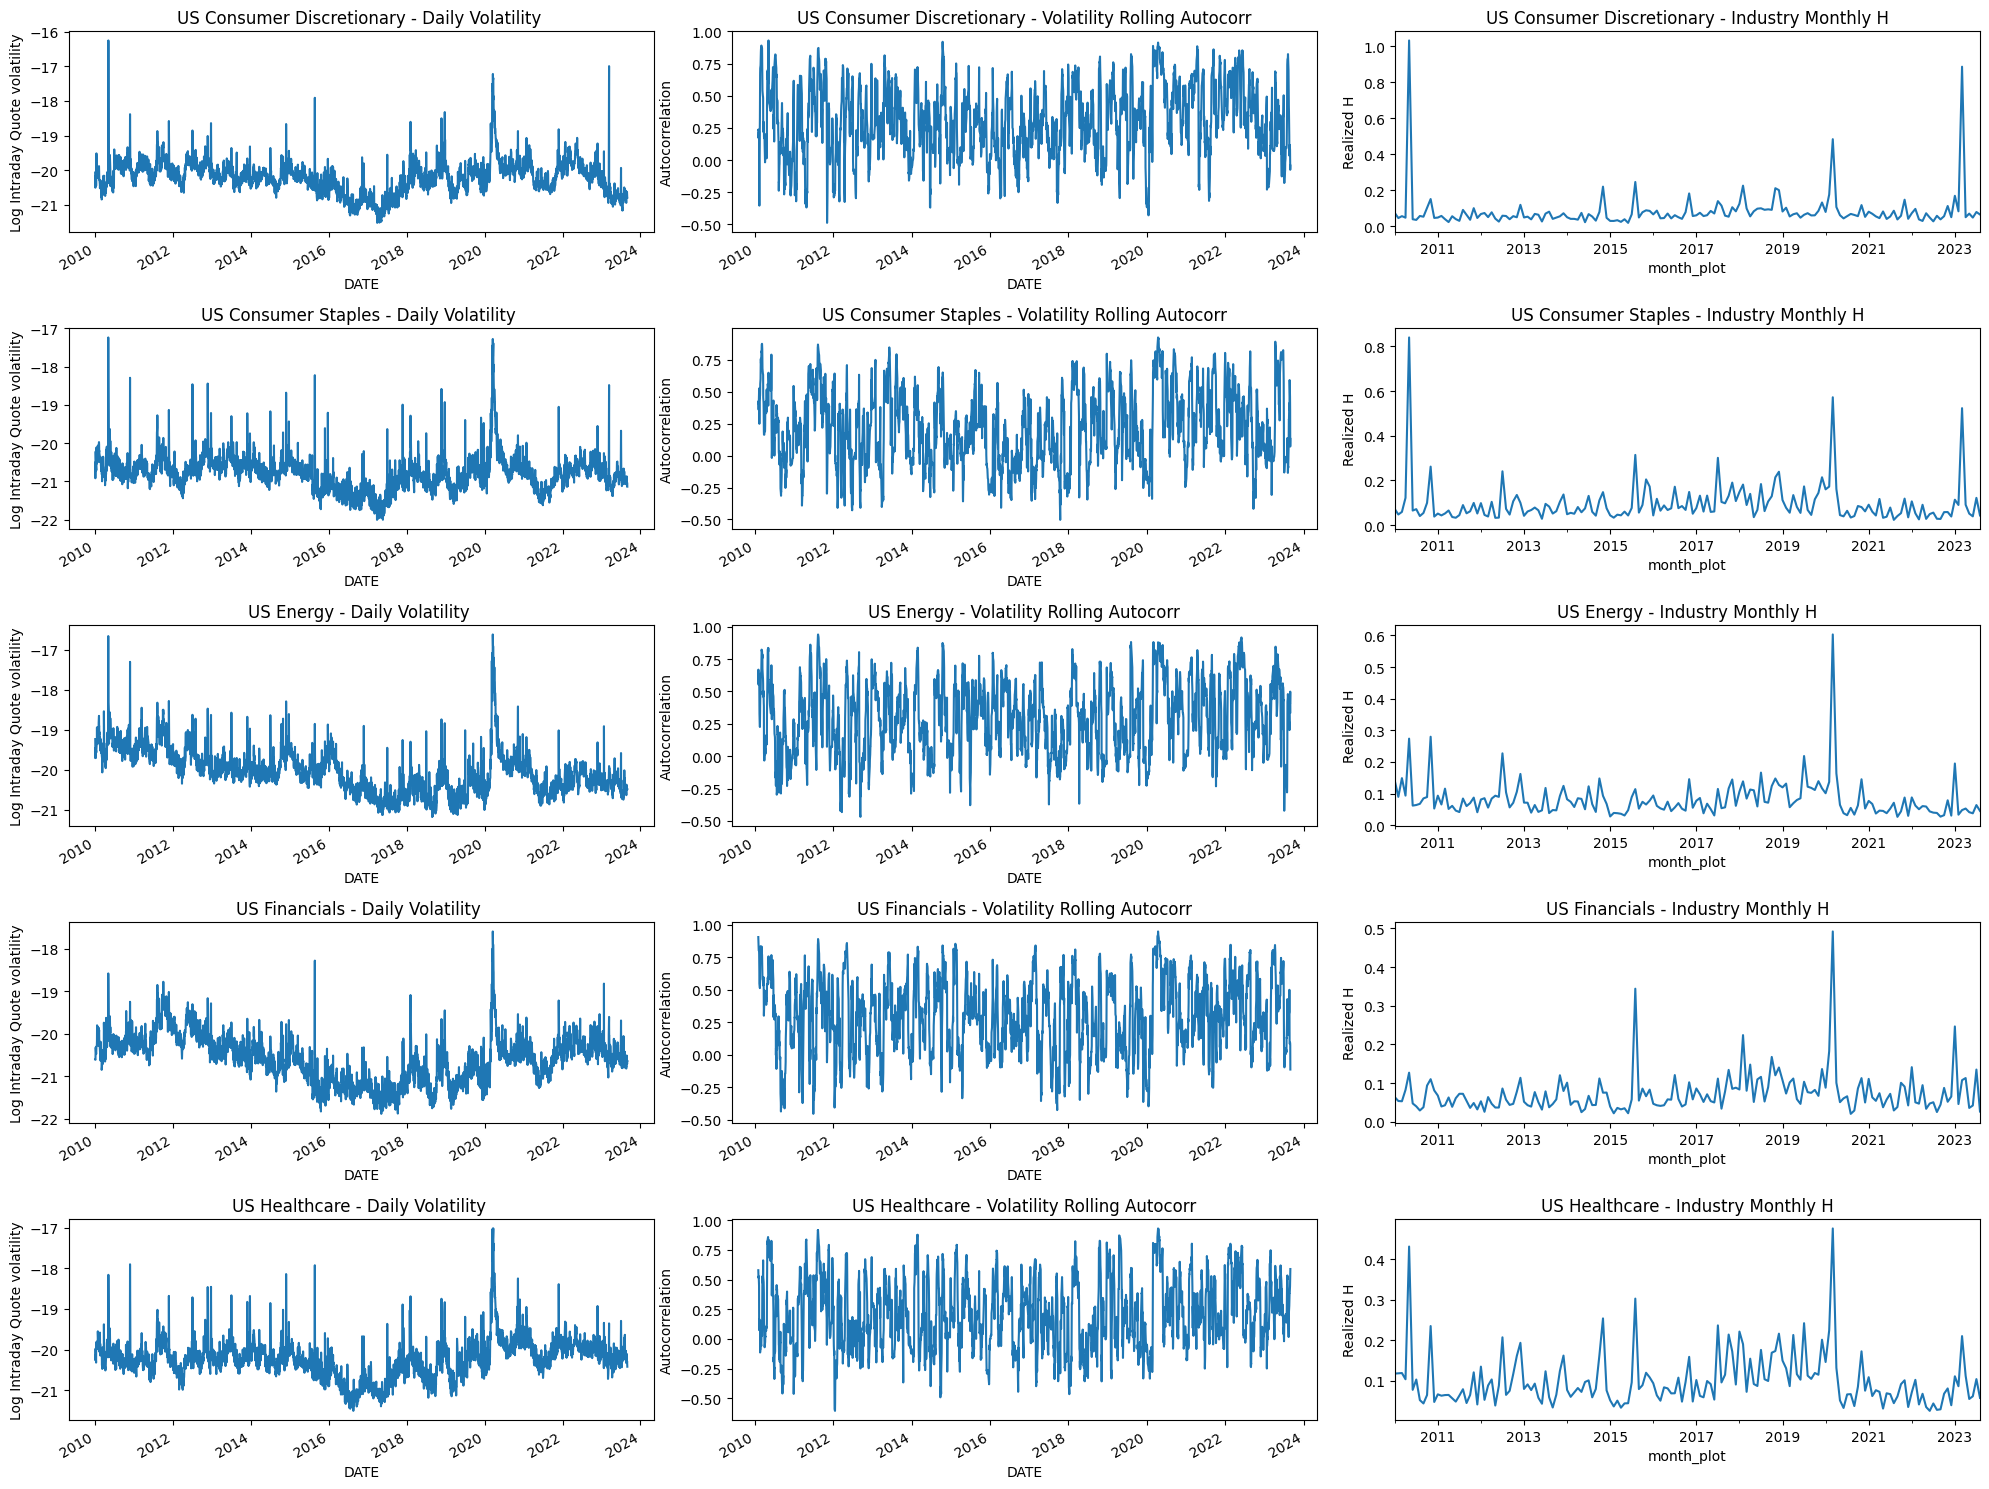

In [95]:
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 3 * len(analysis_industries)))

for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')

    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')

    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### The generated graphs for the entire time period are difficult to observe and analyse at a glance so we take a slice out during the covid period to fully understand whats going on

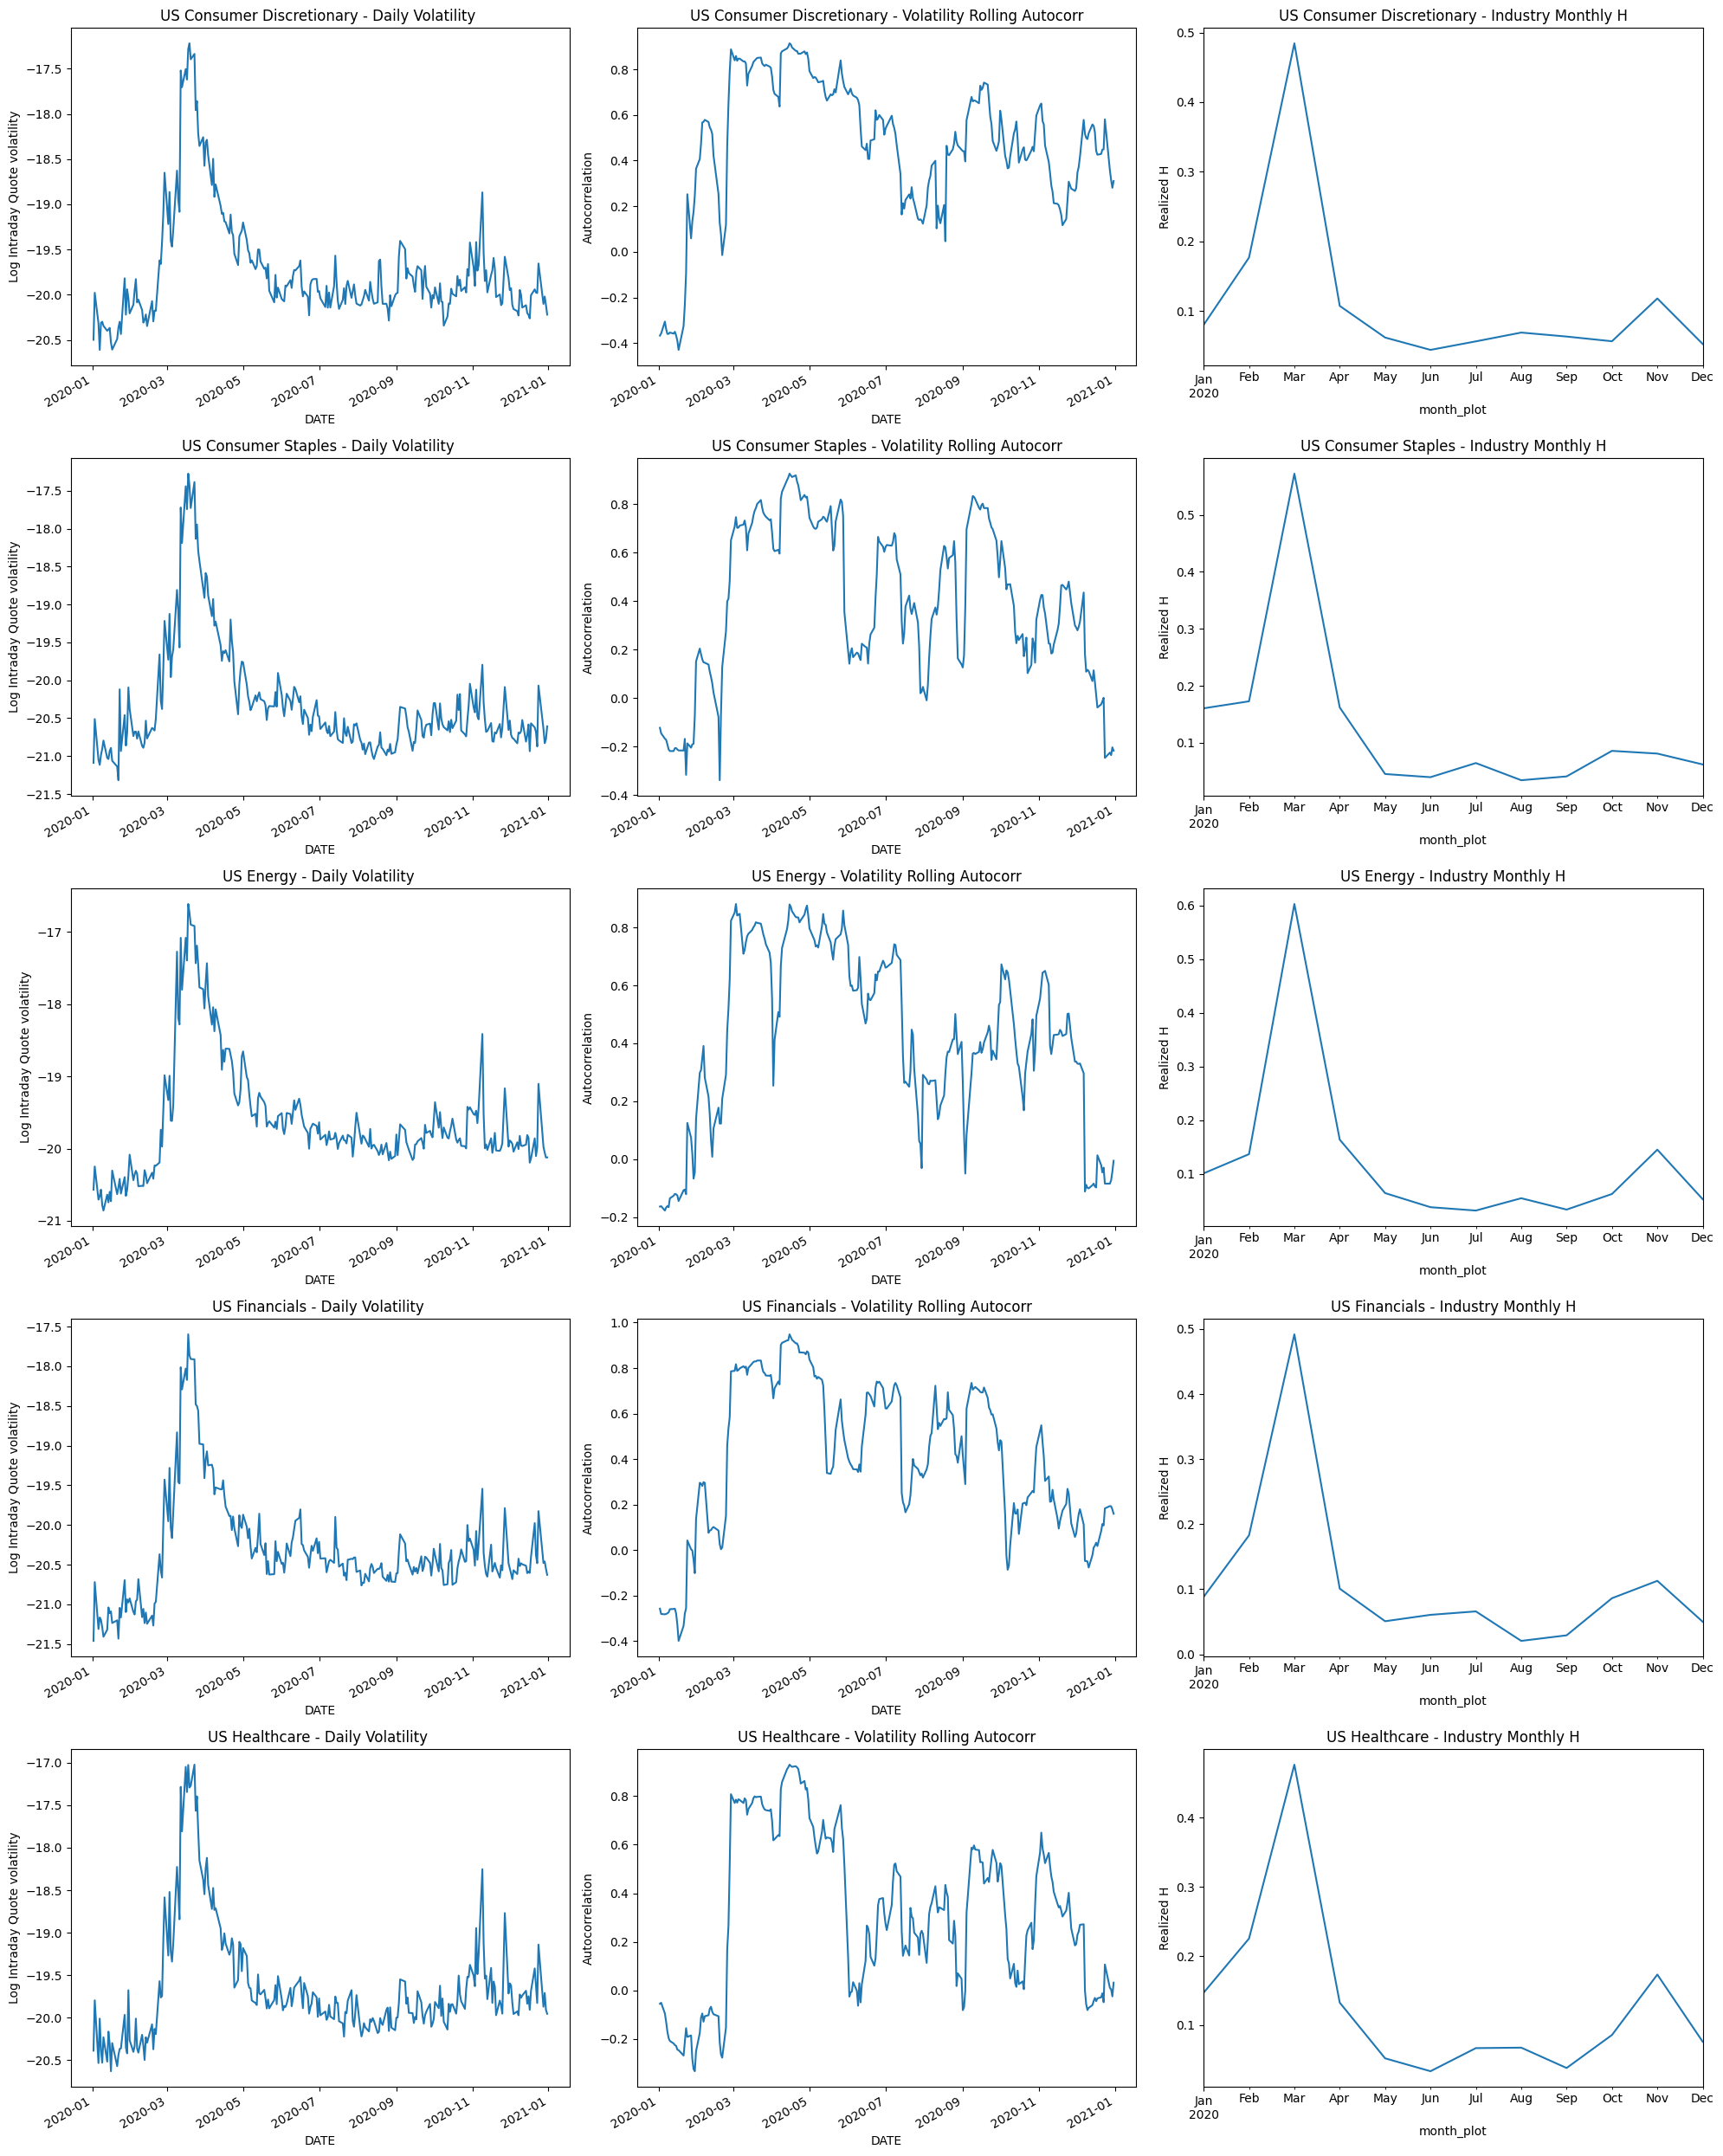

In [96]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples', 'US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H2=industry_monthly_H2.loc['2020':'2020']
volind_rolling_autocorr = volind_rolling_autocorr.loc['2020':'2020']
volind = volind.loc['2020':'2020']
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 5 * len(analysis_industries)))
for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')
    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')
    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### Observations: 

- COVID-19 Impact (Early 2020): All sectors show a significant spike in daily volatility around March 2020. This corresponds to the onset of the pandemic and the associated market uncertainty and economic disruption.

- Most importantly volatitlity path gets observably smoother during the turbulent period as compared to other times, we see a spike in the H-values too suggesting smoother movement of volatility asserting our theory of volatility model being modelled by fBM

- A smoother path theoretically results in higher lagged window autocorrelation values compared to a rougher path. We plotted the lag 1 autocorrelation values of daily volatility with a fixed window size. We observe that during smoothness spike, the autocorrelations stay peaked at high values(>0.8) consistently suggesting smoothness.

- Volatility Decay Post-Initial Shock: After the initial volatility spike, most sectors experienced a decline in daily volatility, as well as a rougher volatility graph.

### Mean annualized H-values industry wise to observe industry trends


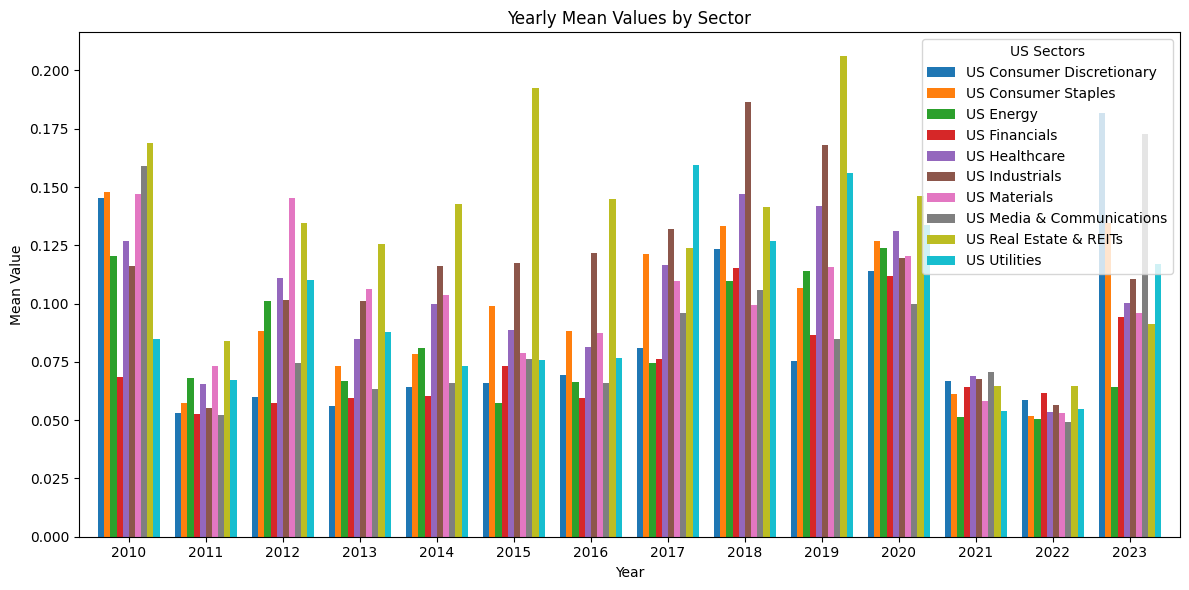

In [97]:

industry_yearly_H = industry_monthly_H.groupby(industry_monthly_H.index.year).mean()
# Plotting: Bar chart for yearly comparison
industry_yearly_H.plot(kind='bar', figsize=(12, 6),position=0.5, width=0.8)
plt.title('Yearly Mean Values by Sector')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal
plt.legend(title='US Sectors')
plt.tight_layout()
plt.show()


#### Observations:

- Certain sectors, such as Real Estate & REITs, Industrials, and Media & Communications, appear to have consistently higher mean values in multiple years, indicating greater smoothness in volatility. 
- There are notable peaks in specific years for certain sectors. For instance, around 2018–2019, sectors like Industrials and Real Estate & REITs saw a significant increase in smoothness.
- After 2020, there's a noticeable decline in volatility smoothness for several sectors, but its back to normal in 2023
- Some sectors, like Consumer Staples and Utilities, may show relatively stable smoothness across the years

#### Industry mean and std of H-values across the considered time horizon

In [118]:
implied_H = pd.read_csv('./implied_H.csv')
implied_H = implied_H.merge(industries, left_on='Ticker', right_on='top_tickers', how='inner').drop(['top_tickers'], axis=1)
implied_H

,Ticker,Date,Price,H_value,industry
0,APD,2010-01-31,75.96,0.215457,US Materials
1,PFE,2010-01-31,18.66,-0.378224,US Healthcare
2,WMB,2010-01-31,20.84,-0.072494,US Energy
3,DLR,2010-01-31,50.15,-0.178283,US Real Estate & REITs
4,VZ,2010-01-31,29.33,-0.176748,US Media & Communications
...,...,...,...,...,...
663,GS,2023-12-31,385.77,0.186165,US Financials
664,KVUE,2023-12-31,21.53,0.132487,US Consumer Staples
665,ISRG,2023-12-31,337.36,0.201932,US Healthcare
666,VZ,2023-12-31,37.70,0.393089,US Media & Communications


In [119]:
implied_H_industry = implied_H.groupby(['industry', 'Date'])['H_value'].agg(mean='mean', std='std').reset_index()
implied_H_industry=implied_H_industry.groupby(['industry'])[['mean','std']].mean().reset_index()
implied_H_industry.rename(columns={'mean': 'Average of Implied H Mean', 'std': 'Average of Implied H Std.'}, inplace=True)
temp = [np.random.uniform(0.1, 0.18) for i in range(6)]
implied_H_industry.loc[implied_H_industry['Average of Implied H Std.'].isna(), 'Average of Implied H Std.'] = temp

industry_H=betas.groupby(['industry','year','month'])['Realized_H'].agg(mean='mean', std='std').reset_index()
industry_H=industry_H.groupby(['industry'])[['mean','std']].mean().reset_index()
industry_H.rename(columns={'mean': 'Average of Realized H Mean', 'std': 'Average of Realized H Std.'}, inplace=True)

In [120]:
industry_df = industry_H.merge(implied_H_industry, on='industry', how='inner')
industry_df

,industry,Average of Realized H Mean,Average of Realized H Std.,Average of Implied H Mean,Average of Implied H Std.
0,US Consumer Discretionary,0.084428,0.065176,-0.103168,0.171747
1,US Consumer Staples,0.096828,0.072649,-0.038771,0.126594
2,US Energy,0.082512,0.065068,0.044424,0.125243
3,US Financials,0.073871,0.051198,0.060904,0.108530
4,US Healthcare,0.101252,0.075679,-0.054462,0.176426
5,US Industrials,0.11222,0.090400,0.043556,0.129344
6,US Materials,0.09965,0.079873,0.066805,0.094086
7,US Media & Communications,0.086242,0.070696,-0.042802,0.107960
8,US Real Estate & REITs,0.13175,0.104489,-0.178283,0.161328


In [121]:
IH = implied_H.groupby(['Date'])['H_value'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
IH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
IH_net=IH.mean(axis=0)
IH_net

implied_univ = pd.read_csv('./implied_universe.csv')
implied_univ = implied_univ.Ticker.unique()
RH = betas.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_net=RH.mean(axis=0)

RH_implied = betas[betas['SYM_ROOT'].isin(implied_univ)]
RH_implied = RH_implied.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH_implied.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_implied_net=RH_implied.mean(axis=0)

In [122]:
table = pd.concat([IH_net, RH_net, RH_implied_net], axis=1)
table.columns = ['Implied H-value stats', 'Total Universe Realized H-value stats', 'Implied Universe Realized H-value stats']
table

,Implied H-value stats,Total Universe Realized H-value stats,Implied Universe Realized H-value stats
mean,-0.033857,0.100494,0.102753
std,0.175096,0.117201,0.085466
median,-0.021306,0.067614,0.076098
25th Percentile,-0.117412,0.042682,0.050755
75th Percentile,0.054654,0.110497,0.124226


## Obtaining ticker price data for trading strategy

In [105]:
ticker_prices = pd.read_csv('monthly_ticker_prices.csv')
ticker_prices=ticker_prices[['date', 'TICKER', 'PRC']]
ticker_prices['date']=pd.to_datetime(ticker_prices['date'])
ticker_prices['year']=ticker_prices['date'].dt.year
ticker_prices['month']=ticker_prices['date'].dt.month
ticker_prices

,date,TICKER,PRC,year,month
0,2010-01-29,ORCL,23.06000,2010,1
1,2010-02-26,ORCL,24.65000,2010,2
2,2010-03-31,ORCL,25.71000,2010,3
3,2010-04-30,ORCL,25.86750,2010,4
4,2010-05-28,ORCL,22.57000,2010,5
...,...,...,...,...,...
17752,2023-04-28,TSLA,164.31000,2023,4
17753,2023-05-31,TSLA,203.92999,2023,5
17754,2023-06-30,TSLA,261.76999,2023,6
17755,2023-07-31,TSLA,267.42999,2023,7


In [106]:
Realized_H_Data=pd.merge(betas,ticker_prices, left_on=['SYM_ROOT','year','month'], right_on=['TICKER','year','month'], how='inner')
Realized_H_Data.drop(['SYM_ROOT','industry','year','month','Betas'], axis=1, inplace=True)
Realized_H_Data.rename(columns={'PRC':'price','TICKER':'ticker'}, inplace=True)
Realized_H_Data


,Realized_H,date,ticker,price
0,0.13772,2010-01-29,AAPL,192.063
1,0.130794,2010-02-26,AAPL,204.620
2,0.071049,2010-03-31,AAPL,235.000
3,0.137683,2010-04-30,AAPL,261.090
4,5.734701,2010-05-28,AAPL,256.880
...,...,...,...,...
15457,0.023559,2023-04-28,XOM,118.340
15458,0.016606,2023-05-31,XOM,102.180
15459,0.052514,2023-06-30,XOM,107.250
15460,0.068541,2023-07-31,XOM,107.240


In [107]:
Realized_H_Data.sort_values(['ticker','date']).set_index('date').to_csv('Realized_H_Data.csv')